# SLIC model on lake data

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [7]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
import matplotlib.pyplot as plt
from phd.helpers import mean
from vessel_manoeuvring_models.angles import smallest_signed_angle
from copy import deepcopy
plt.style.use('bmh')

In [3]:
alpha = 30;

rho = 1025; 
g = 9.81;
L = 206.6/alpha;  
l_cg = -9.8/alpha;  
displ = 30843/(alpha^3)
t_a = 8.5/alpha;    
t_f = 8.5/alpha;    
xx_rud = -99.50537997722316/alpha;  
zz_rud = -4.73/alpha;  

In [4]:
print(f"rho:{rho}") 
print(f"g:{g}") 
print(f"L:{L}") 
print(f"lcg:{l_cg}") 
print(f"disp:{displ}") 
print(f"t_a:{t_a}")   
print(f"t_f:{t_f}")   
print(f"xx_rud:{xx_rud}") 
print(f"zz_rud:{zz_rud}") 

rho:1025
g:9.81
L:6.886666666666667
lcg:-0.3266666666666667
disp:1063.551724137931
t_a:0.2833333333333333
t_f:0.2833333333333333
xx_rud:-3.3168459992407717
zz_rud:-0.15766666666666668


In [5]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [8]:
%reload_kedro
ship='7m'
time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"wPCC.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/17/23 09:02:09] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=506495;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=933764;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/framew ]8;id=255558;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=484275;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             ork/startup.py:98: DeprecationWarning: project_version in                             
                             pyproject.toml is deprecated, use kedro_init_version instead                          
                               warnings.warn(                                                                      
                                                                                                                   

[05/17/23 09:02:09] INFO     Kedro project phd                                                      ]8;id=582894;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=405498;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=325534;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=770145;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=959173;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=168395;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=589161;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=523906;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=653941;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=244554;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=149805;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=240019;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=423215;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=710970;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
ship_data['volume']/(ship_data['L']*ship_data['B']*ship_data['T'])

0.41152752056103203

In [8]:
model_loaders

{'vmm_abkowitz_diminished': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fbad5f75300>>,
 'wpcc.updated.vmm_martins_simple.joined.model': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fbad5f75a80>>}

In [9]:
model_wPCC = model_loaders["vmm_abkowitz_diminished"]()
model = model_wPCC.copy()
model.ship_parameters.update(ship_data)
model = deepcopy(model)
try:
    model_loaders_7m = catalog.load(f"7m.models")
except Exception:
    model_loaders_7m = {}
    
model_loaders_7m["vmm_abkowitz_diminished"] = model

catalog.save(f"7m.models", model_loaders_7m)

[05/17/23 09:02:23] INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=632529;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=133275;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Saving data to '7m.models' (PartitionedDataSet)...                 ]8;id=148373;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=791738;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [10]:
model_wPCC.ship_parameters

{'T': 0.2063106796116504,
 'L': 5.014563106796117,
 'CB': 0.45034232324249973,
 'B': 0.9466019417475728,
 'rho': 1000,
 'x_G': 0,
 'm': 441.0267843660858,
 'I_z': 693.124396594905,
 'volume': 0.4410267843660858,
 'scale_factor': 41.2,
 'x_r': -2.42219908951329,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.12135922330097086,
 'w_p0': 0.151}

In [11]:
model.ship_parameters

{'T': 0.284,
 'L': 7.0,
 'CB': 0.41152752056103203,
 'B': 1.3,
 'rho': 1025,
 'x_G': 0,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'scale_factor': 30,
 'x_r': -3.3168459992407717,
 'TWIN': 1,
 'x_p': -2.42219908951329,
 'D': 0.17,
 'w_p0': 0.151}

In [12]:
model.parameters

Xudot                0.000179
Xdeltadelta         -0.024500
Xrr                 -2.653188
Xuu                -12.736751
Xu                  12.736793
Xvv                 -6.236785
Xrdelta             -1.937870
Xudeltadelta         0.031740
Xurr                 2.723201
Xvdelta             -3.031942
Xvr                 -6.195177
Xurdelta             1.996231
Xuvdelta             3.117066
Xuvr                 6.383978
Yrdot               -0.000303
Yvdot               -0.006109
Ydeltadeltadelta    -0.005331
Ydelta              -0.121869
Yrrr                 0.001843
Yr                   0.234775
Yvvv                -0.148503
Yv                   0.951097
Yrdeltadelta        -0.020008
Yrrdelta            -0.003659
Yudelta              0.270513
Yur                 -0.585187
Yuudelta            -0.144244
Yuur                 0.350828
Yuuv                 1.099600
Yuv                 -2.067323
Yvdeltadelta        -0.022964
Yvrr                -0.048848
Yvvdelta             0.022375
Yvvr      

In [13]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': 0,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17}

In [14]:
parameters = initial_parameters(ship_data=ship_data)
added_masses = extract_added_masses(parameters=parameters)
model.parameters.update(added_masses)

## Lake data

In [15]:
time_series

{'0': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbfbe0>>,
 '1': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbe890>>,
 '10': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbfca0>>,
 '11': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbfe80>>,
 '12': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbee90>>,
 '13': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbf070>>,
 '14': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fcf3bcbfc70>>,
 '15': <bound method AbstractVersionedDataSet.load of <ke

In [16]:
data_raw = time_series['4']()
data_raw = fix_interpolated_angle(data=data_raw, key="awaBowRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaSternRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaBow")
data_raw = fix_interpolated_angle(data=data_raw, key="awaStern")

[05/17/23 09:02:31] INFO     fix_interpolated_angle for awaBowRAW                                      ]8;id=854007;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=269144;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaSternRAW                                    ]8;id=603640;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=113426;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaBow                                         ]8;id=151902;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=902224;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaStern                                       ]8;id=269507;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=343521;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

In [17]:
data_raw.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,mission,date,delta,V,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,global time
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.1214,-0.163385,1.7796,3.4409,3.2506,59.293256,18.321301,0.0212,-2.8797,1.7941,-3.0216,3.5383,-2.9234,2.2584,-3.0280,4.0127,60.0,6.1087,0.0068,-0.0276,0.0007,0.0057,0.0414,-0.1681,-9.8297,-2.8449,1.9034,-3.0297,3.6423,-2.9671,2.6751,4.4382,"ZigZag: start (59.29325104,18.32130241),ZigZag...",2021-04-28 10:56:51.601953,-0.056734,1.7796,6.284785,1.779598,-0.002847,-0.161785,0.0212,0.005502,0.010425,-0.025860,-0.020016,176.314069,1560.669215,1563.313438,175.380951,3464.356878
0.199930,6.1225,-0.165185,1.7817,13.4409,3.4028,59.293259,18.321300,0.0149,-2.8771,1.8055,-3.0188,3.5494,-2.9256,2.2867,-3.0279,4.0416,60.0,6.1087,0.0073,-0.0276,0.0035,0.0038,0.0517,-0.2036,-9.7909,-2.8449,1.9351,-3.0099,3.6745,-2.9563,2.6434,4.4056,NaN,2021-04-28 10:56:51.801883,-0.059390,1.7817,6.287685,1.781682,-0.008018,-0.160685,0.0149,0.001500,-0.021018,0.083642,0.035005,176.258192,1561.044756,1563.690004,175.327983,3464.556808
0.399917,6.1228,-0.155485,1.7775,13.4409,5.4571,59.293262,18.321299,0.0103,-2.8766,1.8093,-3.0176,3.5534,-2.9255,2.3067,-3.0269,4.0616,60.0,6.1087,0.0080,-0.0114,0.0033,0.0043,0.0788,-0.0270,-9.7854,-2.8641,1.8794,-2.9909,3.6236,-2.9304,2.5670,4.3234,NaN,2021-04-28 10:56:52.001870,-0.095244,1.7775,6.278285,1.777479,0.008710,-0.160385,0.0103,0.008501,0.012584,0.121129,-0.035008,176.207806,1561.406866,1564.052393,175.278391,3464.756795
0.599902,6.1245,-0.140185,1.7803,13.4409,9.2897,59.293265,18.321299,0.0105,-2.8786,1.8041,-3.0184,3.5489,-2.9236,2.3185,-3.0253,4.0730,60.0,6.1087,0.0081,0.0155,-0.0027,0.0079,0.0202,-0.2320,-9.7727,-2.9014,1.7430,-3.0237,3.4965,-2.8993,2.4632,4.2122,NaN,2021-04-28 10:56:52.201855,-0.162136,1.7803,6.264685,1.779995,0.032934,-0.158685,0.0105,0.001500,0.015106,-0.005961,0.039984,176.164274,1561.756841,1564.403944,175.239357,3464.956780
0.799961,6.1248,-0.140585,1.7833,13.4409,11.8712,59.293269,18.321298,0.0146,-2.8826,1.7960,-3.0207,3.5424,-2.9229,2.3261,-3.0251,4.0809,60.0,6.1087,0.0072,0.0268,-0.0060,0.0106,0.0358,-0.3286,-9.8280,-2.9276,1.7044,-3.0231,3.4682,-2.9124,2.4246,4.1824,NaN,2021-04-28 10:56:52.401914,-0.207192,1.7833,6.265385,1.783017,0.031741,-0.158385,0.0146,0.009499,-0.033094,-0.144474,0.045035,176.122989,1562.107834,1564.755215,175.198867,3465.156839


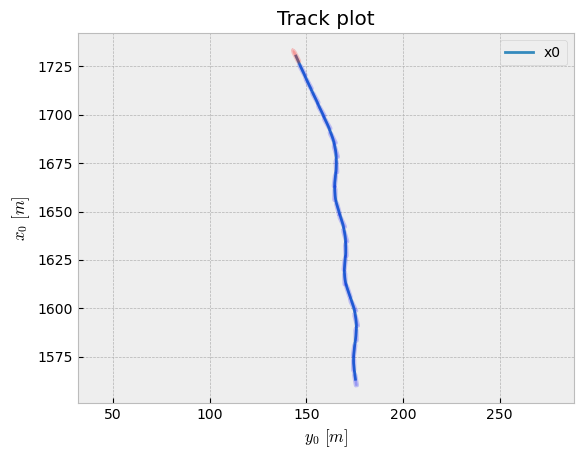

In [18]:
track_plot(df=data_raw, lpp=ship_data['L'], beam=ship_data['B']);

## Kalman filter system matrixes (-> f(...) and jacobi matrix)

In [19]:
system_matrixes = SystemMatrixes(vmm=vmm)

## Extended Kalman Filter

In [20]:
ek = ExtendedKalman(
        vmm=vmm,
        parameters=model.parameters,
        ship_parameters=ship_data,
        system_matrixes=system_matrixes,
    )

In [21]:
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
delta = data_all['delta'] = data_all['delta'] - (data_all['delta'].max() - (data_all['delta'].max() - data_all['delta'].min())/2)
data['delta'] = delta

In [22]:
x0 = initial_state(data)

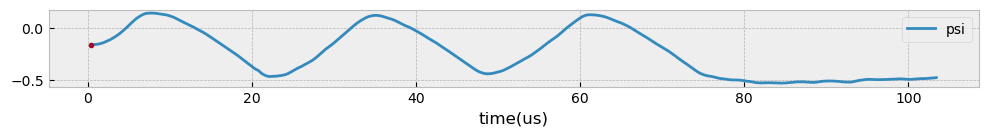

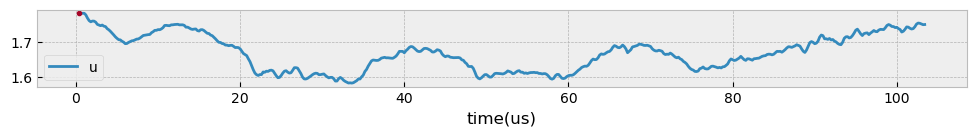

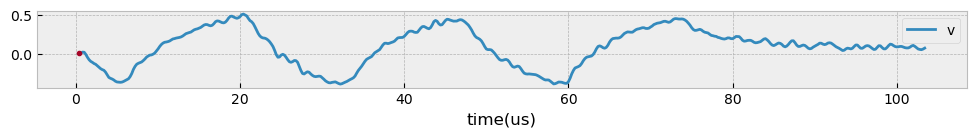

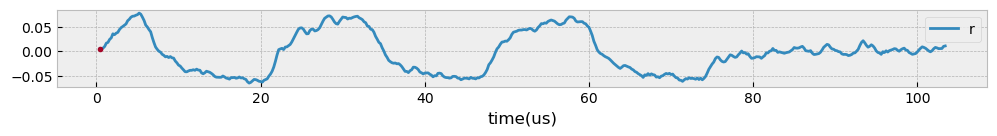

In [23]:
keys = ['psi','u','v','r']
for key in keys:
    fig,ax=plt.subplots()
    fig.set_size_inches(12,1)
    df_ = data.rolling(window=3).mean().dropna()
    df_.plot(y=key, ax=ax)
    ax.plot(df_.index[0],x0[key],'.')
    

In [24]:
ek_covariance_input = yaml.safe_load("""
process_variance:
  u : 0.003
  v : 0.3
  r : 0.019  # [deg]
measurement_error_max:
  positions: 0.05
  psi: 0.5  # [deg]
"""
)     

 
                                     
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input,data=data)
covariance_matrixes['P_prd'][3][3]/=1000

In [25]:
ek2, data_ek, time_steps = extended_kalman_filter(ek=ek, data=data, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=model.parameters)
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek2, data=data, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=model.parameters)

In [26]:
#data = data_raw.drop(columns=['mission','date'])
result = model.simulate(data)

In [27]:
type(data.rolling(5))


pandas.core.window.rolling.Rolling

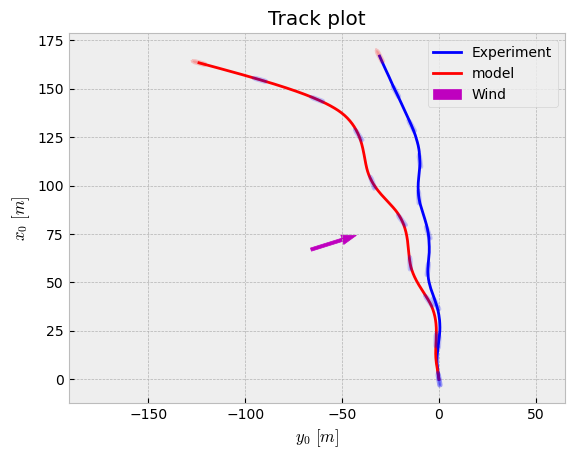

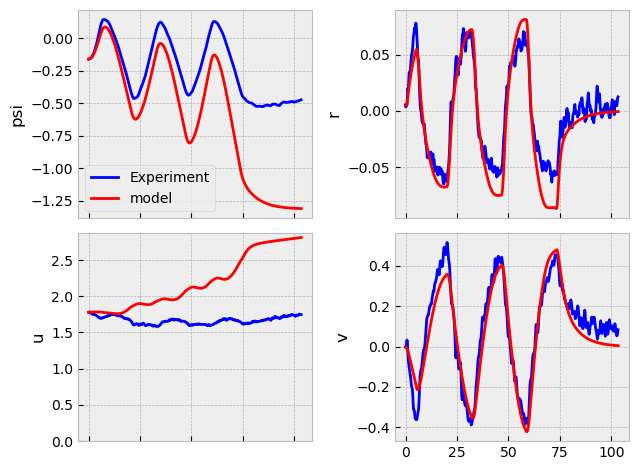

In [28]:
data['twa'] = data['twaBowRAW']
dataframes = {
'Experiment':mean(data.rolling(2)),
#'Experiment':data,
'model' : result.result
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
ax.legend(loc='upper right')

plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);

<Axes: xlabel='time(us)'>

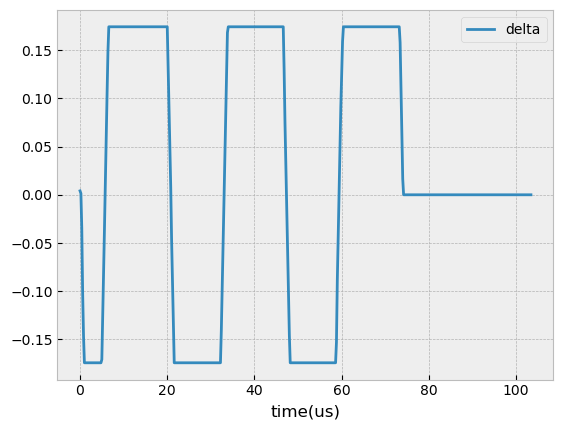

In [29]:
data.plot(y='delta')